In [9]:
from glob import glob
import os
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F

In [77]:
def sample_points_from_gt(
        gt_mask,
        num_fg,
        num_bg,
    ):
    """
    gt_mask: Tensor[H, W] (0/1)
    return:
        fg_points: Tensor[num_fg, 2]
        bg_points: Tensor[num_bg, 2]
    """
    gt_mask = gt_mask.bool()

    fg_coords = torch.nonzero(gt_mask)          # (y, x)
    bg_coords = torch.nonzero(~gt_mask)

    fg_idx = torch.randperm(len(fg_coords))[:num_fg]
    bg_idx = torch.randperm(len(bg_coords))[:num_bg]

    fg_points = fg_coords[fg_idx][:, [1, 0]]    # -> (x, y)
    bg_points = bg_coords[bg_idx][:, [1, 0]]

    return fg_points, bg_points
    
def build_point_inputs(
    gt_mask,
    fg_points,
    bg_points,
    video_H,
    video_W,
    image_size,
    device,
):
    fg_points, bg_points = sample_points_from_gt(gt_mask, fg_points, bg_points)
    points = torch.cat([fg_points, bg_points], dim=0).float()
    labels = torch.cat([
        torch.ones(len(fg_points)),
        torch.zeros(len(bg_points)),
    ])

    # normalize to [0,1]
    points = points / torch.tensor(
        [video_W, video_H], device=points.device, dtype=points.dtype,)

    # scale to model space
    points = points * image_size

    # add batch dim
    points = points.unsqueeze(0).to(device)
    labels = labels.unsqueeze(0).to(device)

    return {
        "point_coords": points,
        "point_labels": labels,
    }
    
def normalization(image):
    image_min = np.min(image)
    image_max = np.max(image)
    image = ((image - image_min)/(image_max-image_min))*255
    return image

def load_image_label(image_path, label_path, obj_id, max_slices=16):
        image_3d = nib.load(image_path)
        data_seg_3d = nib.load(label_path)
        image_3d = image_3d.dataobj
        data_seg_3d = data_seg_3d.dataobj
        
        if image_3d.ndim == 4:
            if image_3d.shape[-1] == 4:
                image_3d = image_3d[..., 2]
            elif image_3d.shape[-1] == 2:
                image_3d = image_3d[..., 0]
                
        image_3d = np.asanyarray(image_3d)
        data_seg_3d = np.asanyarray(data_seg_3d)
        data_seg_3d[data_seg_3d != obj_id] = 0
        
        pos_slices = np.sum(data_seg_3d, axis=(0,1)) > 0
        image_3d = image_3d[:, :, pos_slices]
        data_seg_3d = data_seg_3d[:, :, pos_slices]
        
        if image_3d.shape[-1] > max_slices and max_slices > 0:
            start_slice = np.random.choice(range(image_3d.shape[-1] - max_slices + 1))
            image_3d = image_3d[..., start_slice:start_slice+max_slices]
            data_seg_3d = data_seg_3d[..., start_slice:start_slice+max_slices]

        image_3d = normalization(image_3d)
        image_3d = torch.rot90(torch.tensor(image_3d)).permute(2, 0, 1).unsqueeze(0).unsqueeze(0)
        data_seg_3d = torch.rot90(torch.tensor(data_seg_3d)).permute(2, 0, 1).unsqueeze(0).unsqueeze(0)

        image_3d = F.interpolate(image_3d, size=(image_3d.shape[2], 1024, 1024), mode='trilinear', align_corners=False)
        data_seg_3d = F.interpolate(data_seg_3d, size=(data_seg_3d.shape[2], 1024, 1024), mode='nearest')
        image_3d = image_3d.squeeze(0).repeat(3, 1, 1, 1).permute(1, 0, 2, 3)
        data_seg_3d = data_seg_3d.squeeze(0).squeeze(0)

        return image_3d, data_seg_3d

In [78]:
im, gt = load_image_label(
    "/data/datasets/MSD/Task03_Liver/imagesTr/liver_0.nii.gz",
    "/data/datasets/MSD/Task03_Liver/labelsTr/liver_0.nii.gz",
    1
)

In [79]:
im.shape, gt.shape

(torch.Size([16, 3, 1024, 1024]), torch.Size([16, 1024, 1024]))

In [80]:
point_inputs = build_point_inputs(
    gt_mask=gt[1],
    fg_points=10,
    bg_points=10,
    video_H=1024,
    video_W=1024,
    image_size=1024,
    device='cpu',
)

In [81]:
fg_idx = point_inputs['point_coords'][0, :10].to(torch.int32)
bg_idx = point_inputs['point_coords'][0, 10:].to(torch.int32)

In [82]:
prompts = torch.zeros_like(gt[0])
prompts[fg_idx[:, 1] + 0, fg_idx[:, 0] + 0] = 1
prompts[fg_idx[:, 1] - 1, fg_idx[:, 0] - 1] = 1
prompts[fg_idx[:, 1] - 1, fg_idx[:, 0] + 1] = 1
prompts[fg_idx[:, 1] + 1, fg_idx[:, 0] - 1] = 1
prompts[fg_idx[:, 1] + 1, fg_idx[:, 0] + 1] = 1
prompts[fg_idx[:, 1] - 2, fg_idx[:, 0] - 2] = 1
prompts[fg_idx[:, 1] - 2, fg_idx[:, 0] + 2] = 1
prompts[fg_idx[:, 1] + 2, fg_idx[:, 0] - 2] = 1
prompts[fg_idx[:, 1] + 2, fg_idx[:, 0] + 2] = 1
prompts[fg_idx[:, 1] - 3, fg_idx[:, 0] - 3] = 1
prompts[fg_idx[:, 1] - 3, fg_idx[:, 0] + 3] = 1
prompts[fg_idx[:, 1] + 3, fg_idx[:, 0] - 3] = 1
prompts[fg_idx[:, 1] + 3, fg_idx[:, 0] + 3] = 1

prompts[bg_idx[:, 1] + 0, bg_idx[:, 0] + 0] = 2
prompts[bg_idx[:, 1] - 1, bg_idx[:, 0] - 1] = 2
prompts[bg_idx[:, 1] - 1, bg_idx[:, 0] + 1] = 2
prompts[bg_idx[:, 1] + 1, bg_idx[:, 0] - 1] = 2
prompts[bg_idx[:, 1] + 1, bg_idx[:, 0] + 1] = 2
prompts[bg_idx[:, 1] - 2, bg_idx[:, 0] - 2] = 2
prompts[bg_idx[:, 1] - 2, bg_idx[:, 0] + 2] = 2
prompts[bg_idx[:, 1] + 2, bg_idx[:, 0] - 2] = 2
prompts[bg_idx[:, 1] + 2, bg_idx[:, 0] + 2] = 2
prompts[bg_idx[:, 1] - 3, bg_idx[:, 0] - 3] = 2
prompts[bg_idx[:, 1] - 3, bg_idx[:, 0] + 3] = 2
prompts[bg_idx[:, 1] + 3, bg_idx[:, 0] - 3] = 2
prompts[bg_idx[:, 1] + 3, bg_idx[:, 0] + 3] = 2

In [83]:
prompts.unique()

tensor([0, 1, 2], dtype=torch.uint8)

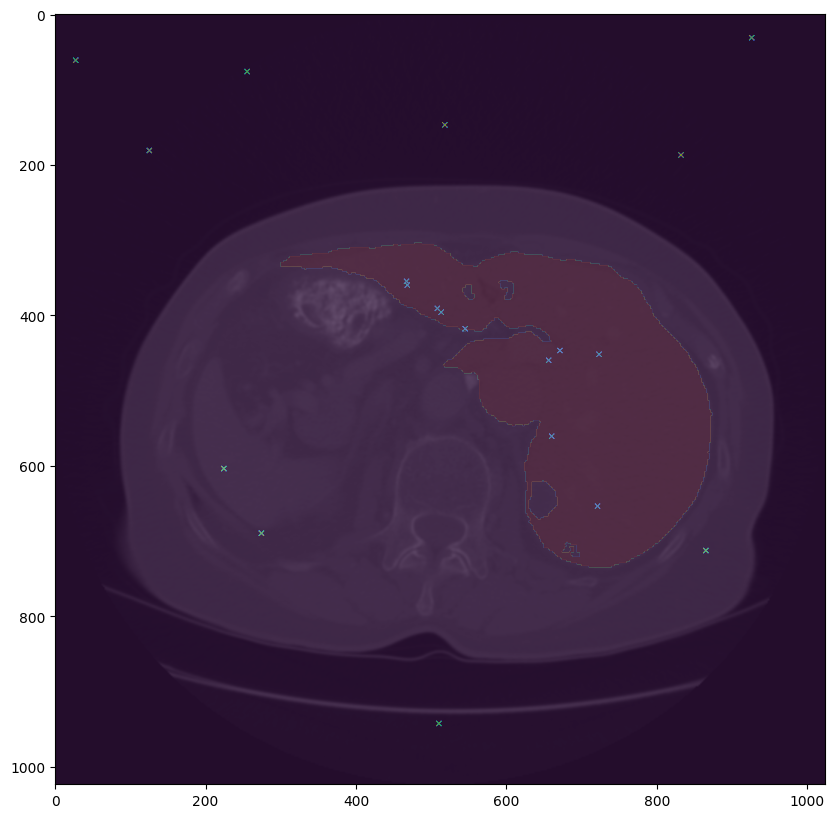

In [84]:
plt.figure(figsize=(10, 10))
plt.imshow(im[1, 0, :, :], cmap="grey")
plt.imshow(gt[1], alpha=0.4, cmap="turbo")
plt.imshow(prompts, alpha=0.6, cmap="turbo")